In [25]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser
from dynamic_env.env_config import EnvConfig


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome
from grid_world.graph import Graph
from grid_world.node import Node
from grid_world.tasks import *
import grid_world.generate_gif as grid_gen
from copy import deepcopy
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageChops
from mpl_toolkits.axes_grid1 import ImageGrid

import networkx as nx
import pygraphviz as pgv
import IPython.display 

In [2]:
def get_robot(genome, neat_config, env, genome_type):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(5, genome_type)
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, 5)
        
    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    
    env = evogym.envs.gym.make(env, body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [3]:
with open(f"../island_cp_v2/snk_3d/grid_gen_1500.pkl", "rb") as file:
    grid: Graph = pkl.load(file)
genome_type = grid.params.substrate_type
CustomGenome.robot_func = lambda self, net, config: generate_robot(net, grid.d_nodes["0"].sgr_pop.robot_size)
CustomGenome.substrate = morph_substrate(grid.d_nodes["0"].sgr_pop.robot_size, genome_type)
CustomGenome.robot_size = grid.d_nodes["0"].sgr_pop.robot_size
CustomGenome.spec_genotype_weight =  grid.params.spec_genotype_weight
CustomGenome.spec_phenotype_weight = grid.params.spec_phenotype_weight

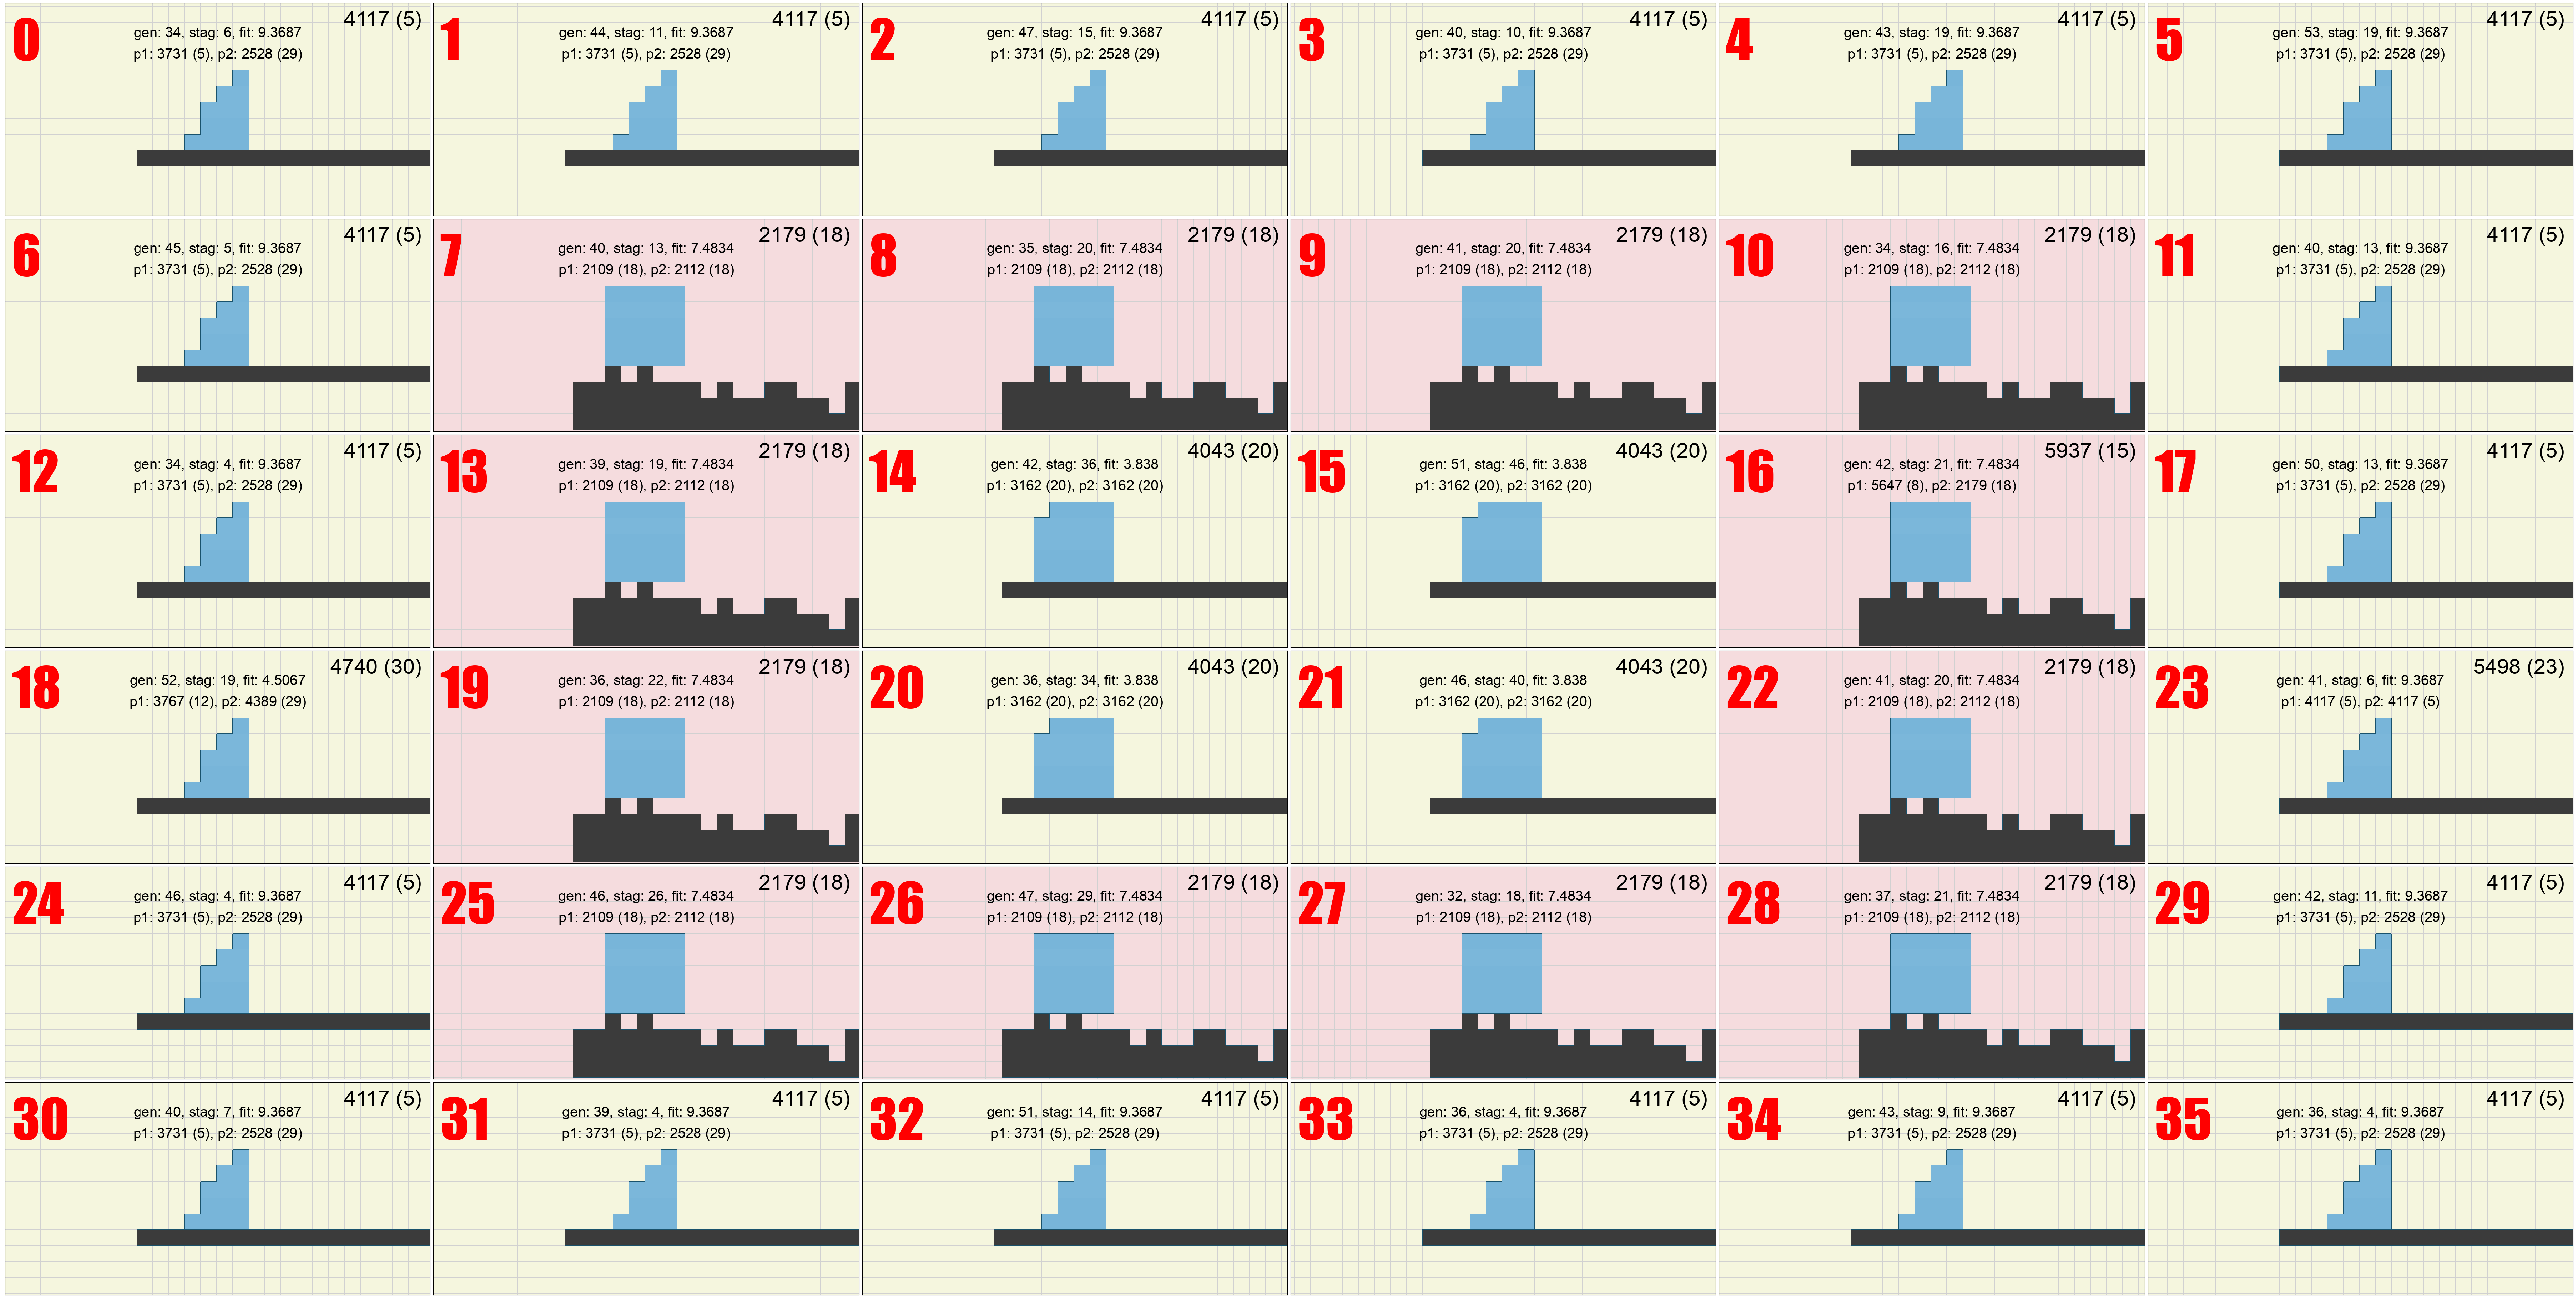

In [4]:
n_rows=6
n_cols=6
fig = grid_gen.generate_grid(grid, n_rows, n_cols, genome_type)

In [5]:
print(grid.d_historical[4043].__dict__)

print(grid.d_historical[3162].__dict__)

print(grid.d_historical[2996].__dict__)
print(grid.d_historical[1755].__dict__)

print(grid.d_historical[2802].__dict__)
print(grid.d_historical[1928].__dict__)
print(grid.d_historical[616].__dict__)


{'id': 4043, 'pop_id': 20, 'parent_1': 3162, 'parent_2': 3162}
{'id': 3162, 'pop_id': 20, 'parent_1': 2996, 'parent_2': 1755}
{'id': 2996, 'pop_id': 26, 'parent_1': 2802, 'parent_2': 1928}
{'id': 1755, 'pop_id': 21, 'parent_1': 616, 'parent_2': 616}
{'id': 2802, 'pop_id': 33, 'parent_1': 2179, 'parent_2': 2781}
{'id': 1928, 'pop_id': 30, 'parent_1': 1752, 'parent_2': 1814}
{'id': 616, 'pop_id': 20, 'parent_1': 505, 'parent_2': 505}


In [6]:
print(grid.d_historical[4117].__dict__)

print(grid.d_historical[3731].__dict__)
print(grid.d_historical[2528].__dict__)


print(grid.d_historical[1164].__dict__)
print(grid.d_historical[2302].__dict__)

{'id': 4117, 'pop_id': 5, 'parent_1': 3731, 'parent_2': 2528}
{'id': 3731, 'pop_id': 5, 'parent_1': 2528, 'parent_2': 2528}
{'id': 2528, 'pop_id': 29, 'parent_1': 1164, 'parent_2': 2302}
{'id': 1164, 'pop_id': 24, 'parent_1': 705, 'parent_2': 805}
{'id': 2302, 'pop_id': 23, 'parent_1': 1164, 'parent_2': 2252}


In [49]:
def create_gen_tree(d_historical, graph, g_id, curr_depth):
    if curr_depth == 0:
        return
    hist = d_historical[g_id]
    p1, p2 = hist.parent_1, hist.parent_2
    
    g_name = f"{g_id} ({hist.pop_id})"
    if p1 == -1 or p2 == -1:
        
        A.add_node(g_name, color="purple")
        return
    
    p1_name = f"{p1} ({d_historical[p1].pop_id})"
    p2_name = f"{p2} ({d_historical[p2].pop_id})"
    
    
    
    if p1 == p2:
        graph.add_edge(p1_name, g_name, color="green")
    else:
        graph.add_edge(p1_name, g_name, color="red")
        graph.add_edge(p2_name, g_name, color="blue")
    
    create_gen_tree(d_historical, graph, p1, curr_depth-1)
    create_gen_tree(d_historical, graph, p2, curr_depth-1)

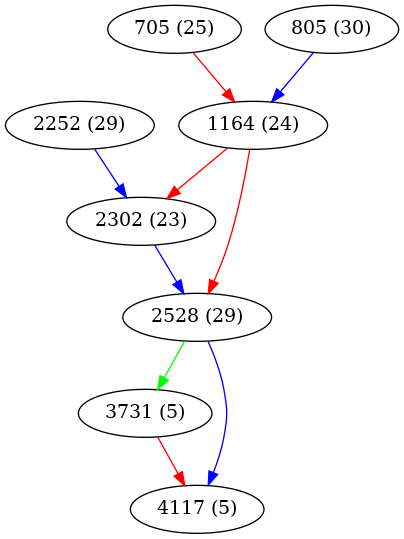

In [55]:
genome_id = 4117
max_depth = 3

A = pgv.AGraph(directed=True, strict=True, rankdir="TB")
create_gen_tree(grid.d_historical, A, genome_id, max_depth)
A.graph_attr["epsilon"] = "0.001"
img = IPython.display.Image(A.draw(format='png', prog='dot'))
display(img)

In [10]:
G = nx.Graph()
G.add_edge(1, 2, color="red")
G.add_edge(2, 3, color="red")
G.add_node(3)
G.add_node(4)

A = nx.nx_agraph.to_agraph(G)  # convert to a graphviz graph
A.draw("attributes.png", prog="neato")  # Draw with pygraphviz

# convert back to networkx Graph with attributes on edges and
# default attributes as dictionary data
X = nx.nx_agraph.from_agraph(A)
print("edges")
print(list(X.edges(data=True)))
print("default graph attributes")
print(X.graph)
print("node node attributes")
print(X.nodes.data(True))

edges
[('1', '2', {'color': 'red'}), ('2', '3', {'color': 'red'})]
default graph attributes
{'graph': {}, 'node': {}, 'edge': {'color': ''}}
node node attributes
[('1', {}), ('2', {}), ('3', {}), ('4', {})]
